In [1]:
# load packages
import json
import pickle
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from lightgbm import LGBMRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.neighbors import KNeighborsRegressor

from model_generator_timeseries import generate_df, timeseries_model 

warnings.filterwarnings('ignore')
% matplotlib inline

### Generate DataFrame
* Generate a ``pandas.DataFrame`` object containing the required features and output to train the Machine Learning (ML) model.
* The target of the ML model is to predict the hourly secondary band price of the Spanish electricity system. The data is available until 2017-05-01.
* A feature engineering step has been applied to the raw features to increase model performance

In [2]:
# this is a dict containing the label of the feature and the csv file path
paths_dict_band = json.load(open('json/paths_dict_band.json', 'r'))

# instantiate the generate_df class
band = generate_df(paths_dict_band, 'band', '2017-05-01')

name_list_24 = ['band']

# obtain the df after feature engineering
feature_eng_df = band.return_df_feature_engineering(name_list_24)

# features to use as X input for the ML model
features_list = json.load(open('json/feature_list_band.json', 'r'))
print('Feature space dimension: %d' %len(features_list))

Feature space dimension: 85


### Load out-of-sample predictions
These are the historical out-of-sample predictions generated by each one of the ML models of the first layer. 

They have been generated with the same hyperparameters shown below. However, they have been stored in order to save computation time and presente later just a small sample for each model. 

In [3]:
lgbm_predictions = pd.read_json('predictions/lgbm_predictions.json', orient='records')
rf_predictions = pd.read_json('predictions/rf_predictions.json', orient='records')
knn_predictions = pd.read_json('predictions/knn_predictions.json', orient='records')
for df in [lgbm_predictions, rf_predictions, knn_predictions]:
    df.index.name = 'date_hour'

In [4]:
lgbm_predictions.head()

,error,y_pred,y_true
date_hour,,,
2016-01-31 00:00:00,7.343949,19.956051,27.30
2016-01-31 01:00:00,7.015639,25.984361,33.00
2016-01-31 02:00:00,-0.528155,31.438155,30.91
2016-01-31 03:00:00,-0.131629,33.131629,33.00
2016-01-31 04:00:00,-8.843400,35.313400,26.47


### Train model timeseries based
Once the data has been preprocessed, three different ML models are trained and tested.

These three models are:
* Light Gradient Boosting
* Random Forest
* K-nearest neighbours

They comprise the first layer of the global ML model; each model takes as input the raw and the feature engineered variables from the Spanish electricity system operator, yielding a prediction of the hourly secondary band price for the following day.

The output of each single model is kept as out-of-sample predictions that will be used on the next layer of the ML model.

In order to train the models, a `timeseries_model` has been created to facilitate the whole process, given that the cross-validation followed has special characteristics.

In this example, each `timeseries_model` is initiated with the same input DataFrame, features and period to predict (from 2017-03-18 to 2016-04-30). Also the training period starts on 2016-01-01 without rolling window.

#### LightGBM

In [5]:
# define pipeline
pipeline = LGBMRegressor(num_leaves=40, learning_rate=0.02, n_estimators=1000)

# create model using timeseries_model class
lgbm_model_no_rolling = timeseries_model(
    feature_eng_df, features_list, 'band', '2016-01-01', '2017-04-30', 
    30, pipeline, '2017-03-18', rolling=False
)

# call to cv_scores method in order to get out-of-sample predictions.
lgbm_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Mean absolute error: 2.8914 +- 3.5542
Mean squared error: 15.6584 +- 56.7655


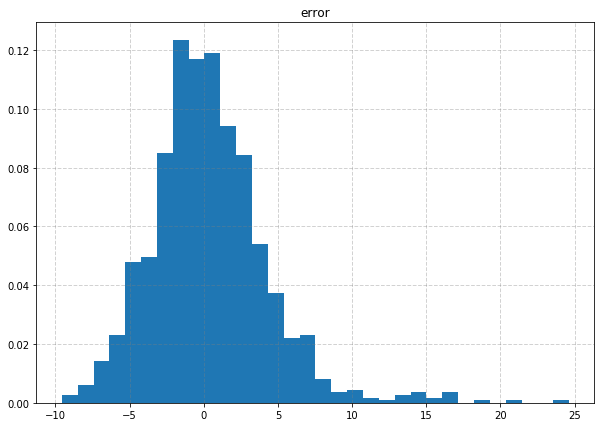

In [6]:
lgbm_model_no_rolling.plot_histogram_error()

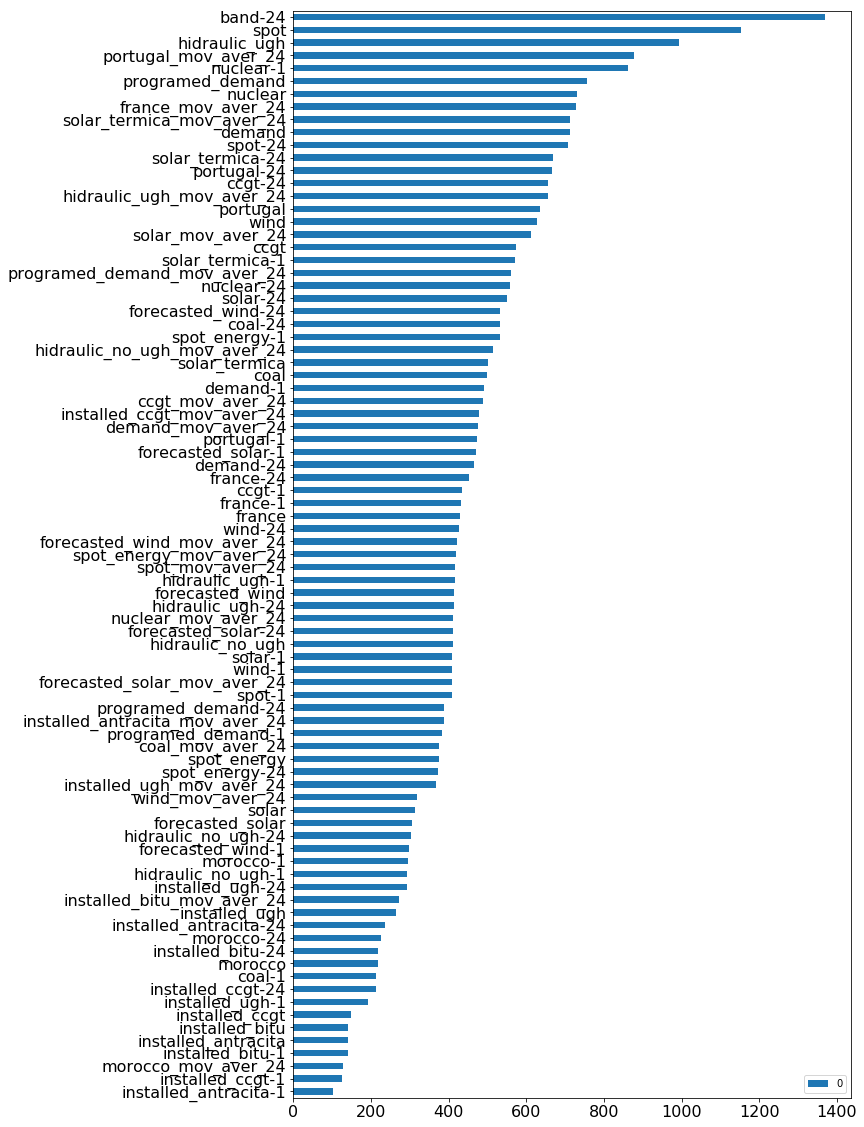

In [7]:
lgbm_model_no_rolling.get_feature_importance()

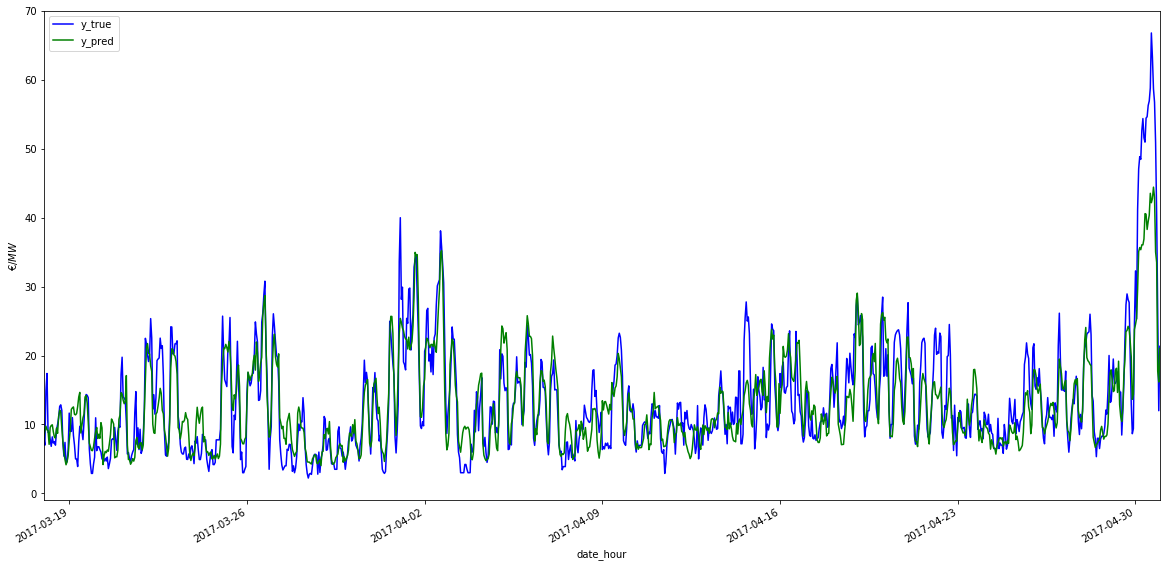

In [8]:
fig, ax = plt.subplots(figsize=(20,10))
lgbm_model_no_rolling.result_df[['y_true', 'y_pred']].plot(ax=ax, color=['blue', 'green'])
ax.set_ylabel('$€/MW$');

#### Random Forest

In [9]:
rf_pipeline = make_pipeline(
    Imputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, max_depth=9, 
        max_features='sqrt', max_leaf_nodes=200, 
        n_jobs=-1, random_state=0, min_samples_split=80,
        min_samples_leaf=25)
)

rf_model_no_rolling = timeseries_model(
    feature_eng_df, features_list, 'band', '2016-01-01', '2017-04-30', 
    30, rf_pipeline, '2017-03-18', rolling=False
)

rf_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Mean absolute error: 3.6876 +- 5.5360
Mean squared error: 27.8386 +- 140.3898


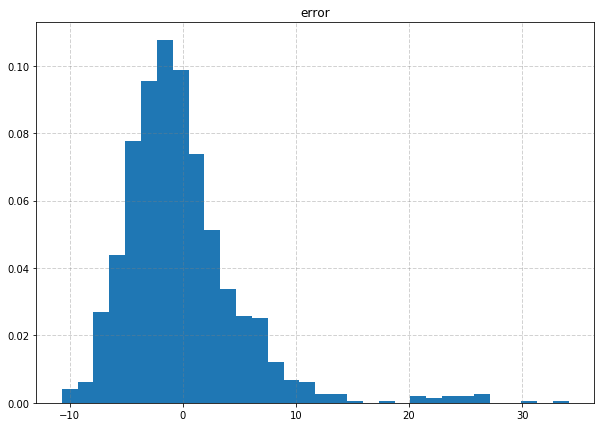

In [10]:
rf_model_no_rolling.plot_histogram_error()

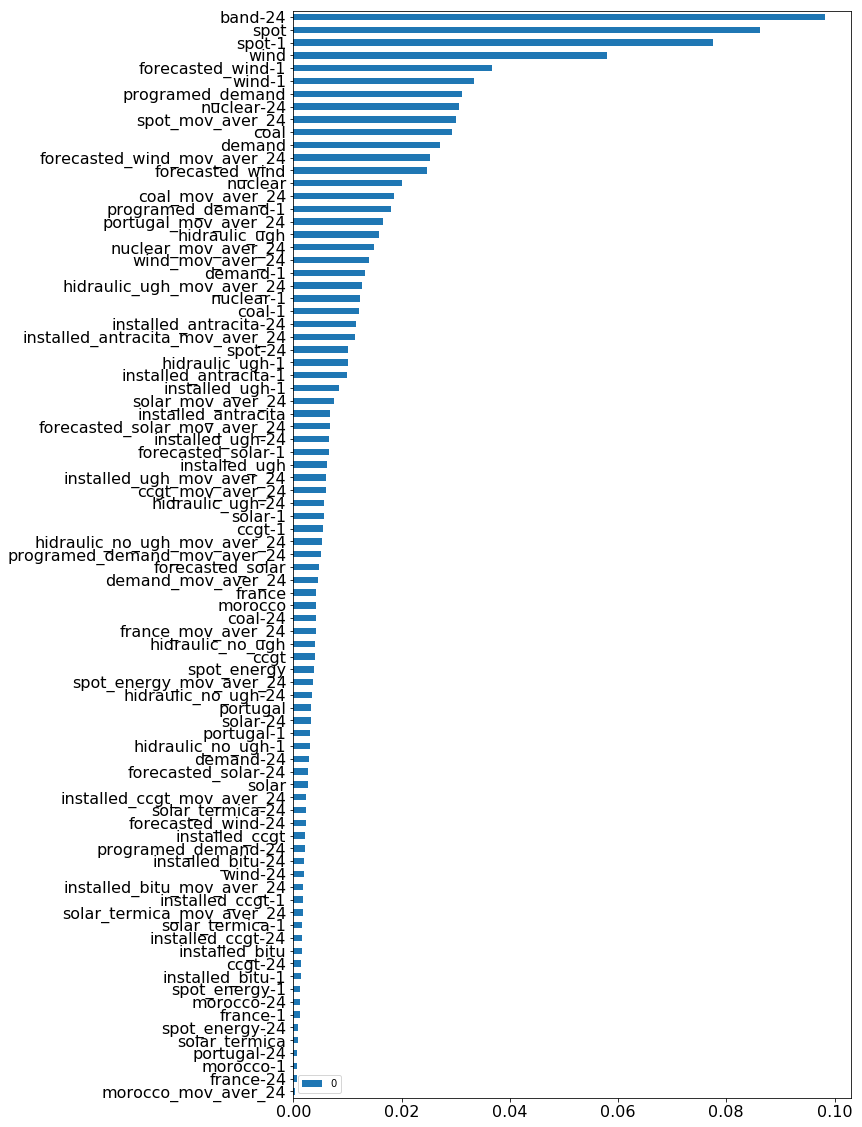

In [11]:
rf_model_no_rolling.get_feature_importance()

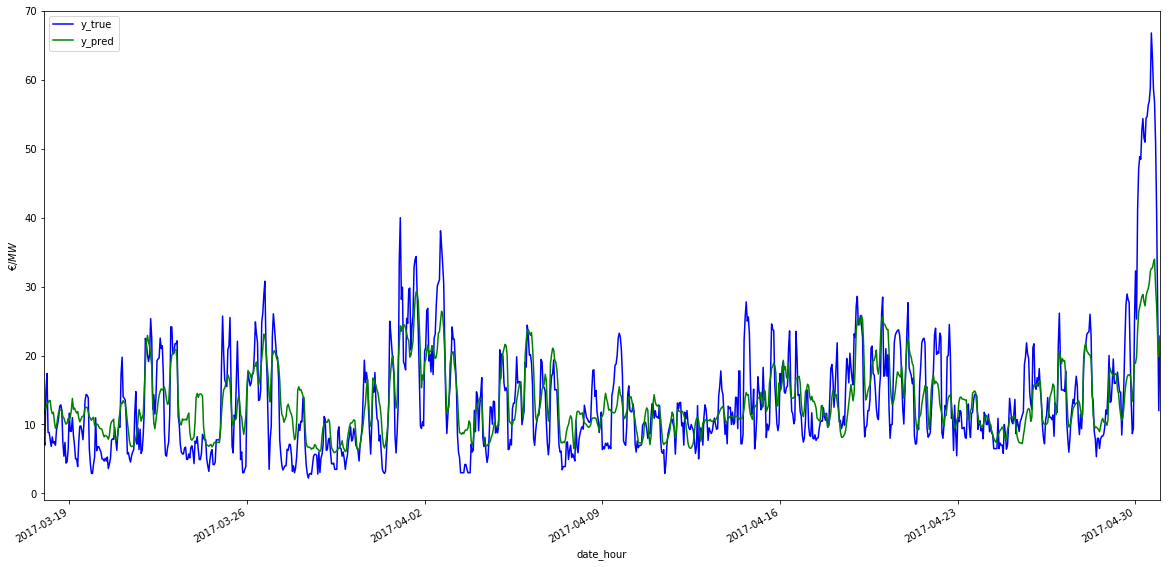

In [12]:
fig, ax = plt.subplots(figsize=(20,10))
rf_model_no_rolling.result_df[['y_true','y_pred']].plot(ax=ax, color=['blue', 'green'])
ax.set_ylabel('$€/MW$');

#### K-Nearest Neighbours

In [13]:
knn_pipeline = make_pipeline(
    Imputer(strategy='median'),
    StandardScaler(),
    KNeighborsRegressor(n_neighbors=20, weights='distance', leaf_size=30,p=2, n_jobs=-1)
)

knn_model_no_rolling = timeseries_model(
    feature_eng_df, features_list, 'band', '2016-01-01', '2017-04-30', 
    30, knn_pipeline, '2017-03-18', rolling=False
)

knn_model_no_rolling.obtain_cv_scores()

Acting on fold 10
Acting on fold 20
Acting on fold 30
Acting on fold 40
Mean absolute error: 4.0916 +- 7.7160
Mean squared error: 41.8374 +- 245.8168


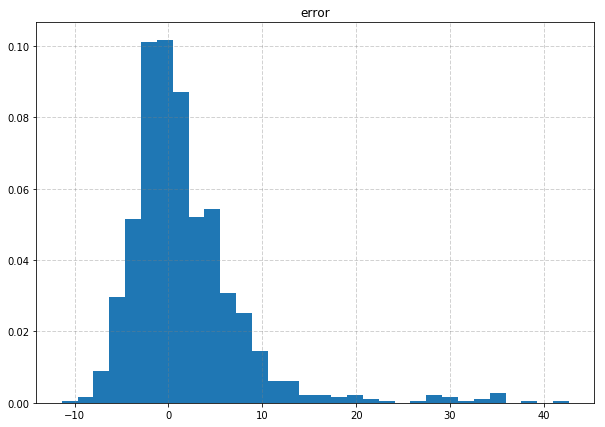

In [14]:
knn_model_no_rolling.plot_histogram_error()

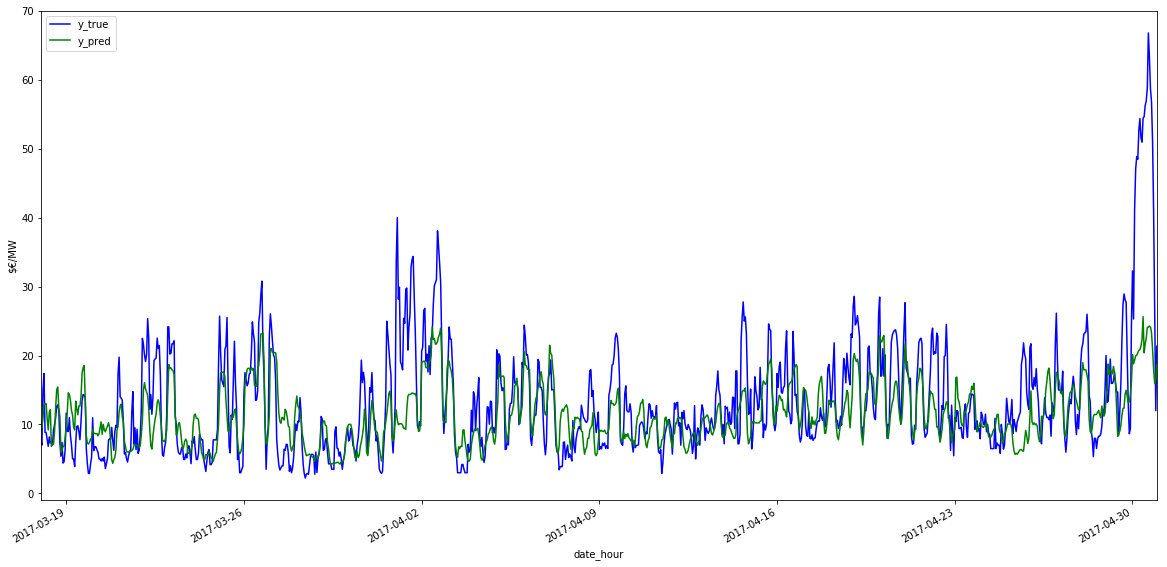

In [15]:
fig, ax = plt.subplots(figsize=(20, 10))
knn_model_no_rolling.result_df[['y_true', 'y_pred']].plot(ax=ax, color=['blue', 'green'])
ax.set_ylabel('$€/MW');

### Plot true values and predictions

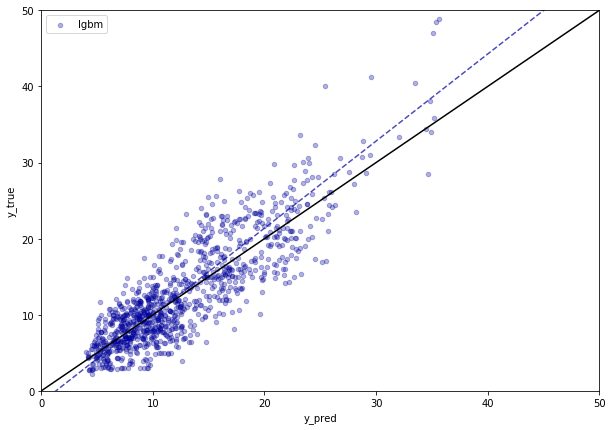

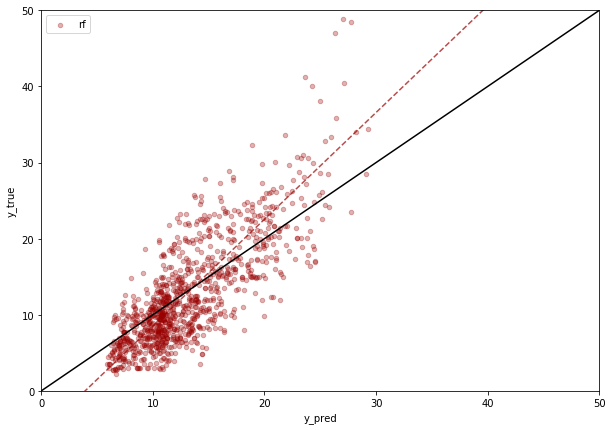

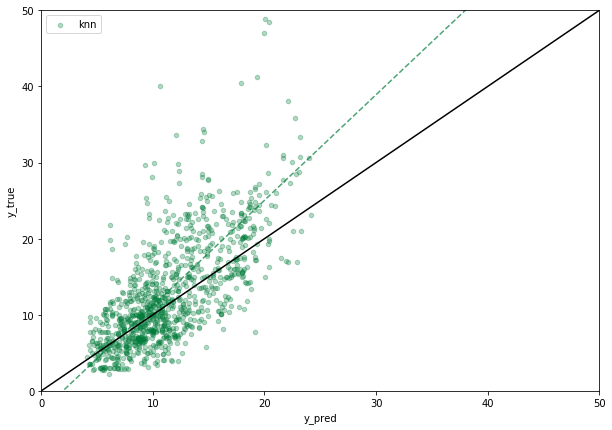

In [16]:
for name, color, df in zip(['lgbm','rf','knn'],
                           ['#00029b','#9b0000','#017c3a'],
                           [lgbm_model_no_rolling, rf_model_no_rolling, knn_model_no_rolling]):
    fig, ax = plt.subplots(1,1, figsize=(10,7))
    df.result_df[['y_pred', 'y_true']].plot.scatter(
        x='y_pred', y='y_true', 
        alpha=0.3, ax=ax, 
        label=name, 
        color=color,
        linewidths=1.0
    )
    z = np.polyfit(df.result_df['y_pred'],df.result_df['y_true'],1)
    p = np.poly1d(z)
    ax.plot(
        np.arange(55), 
        p(np.arange(55)), 
        color=color,
        ls='--', lw=1.5, alpha=0.7
    )
    ax.plot(np.arange(55), np.arange(55), color='black')
    ax.set_xlim([0,50])
    ax.set_ylim([0,50]);

#### Update predictions

In [17]:
lgbm_predictions = pd.concat([
    lgbm_predictions, 
    lgbm_model_no_rolling.result_df[
        lgbm_model_no_rolling.result_df.index.date > lgbm_predictions.index.date[-1]
    ]
])
rf_predictions = pd.concat([
    rf_predictions, 
    rf_model_no_rolling.result_df[
        rf_model_no_rolling.result_df.index.date > rf_predictions.index.date[-1]
    ]
])
knn_predictions = pd.concat([
    knn_predictions, 
    knn_model_no_rolling.result_df[
        knn_model_no_rolling.result_df.index.date > knn_predictions.index.date[-1]
    ]
])

#### Export predictions

In [18]:
lgbm_predictions.to_json('predictions/lgbm_predictions.json')
rf_predictions.to_json('predictions/rf_predictions.json')
knn_predictions.to_json('predictions/knn_predictions.json')

#### Export models

In [19]:
with open('saved_models/lgbm_pipeline.p', 'wb') as f:
    pickle.dump(lgbm_model_no_rolling.pipeline, f)
    
with open('saved_models/rf_pipeline.p', 'wb') as f:
    pickle.dump(rf_model_no_rolling.pipeline, f)
    
with open('saved_models/knn_pipeline.p', 'wb') as f:
    pickle.dump(knn_model_no_rolling.pipeline, f)